In [1]:
import numpy as np
import pandas as pd
import random
import time
import psutil

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from deap import base, creator, tools, algorithms  # Para Algoritmo Genético
from scipy.optimize import differential_evolution  # Para Evolução Diferencial

In [2]:
data = pd.read_csv('../data/heart_disease.csv')

In [3]:
data.head(5)

,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,...,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status
0,56.0,Male,153.0,155.0,High,Yes,Yes,No,24.991591,Yes,...,No,High,Medium,7.633228,Medium,342.0,NaN,12.969246,12.387250,No
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,...,No,Medium,High,8.744034,Medium,133.0,157.0,9.355389,19.298875,No
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,...,Yes,Low,Low,4.440440,Low,393.0,92.0,12.709873,11.230926,No
3,32.0,Female,122.0,293.0,High,Yes,Yes,No,24.130477,Yes,...,Yes,Low,High,5.249405,High,293.0,94.0,12.509046,5.961958,No
4,60.0,Male,166.0,242.0,Low,Yes,Yes,Yes,20.486289,Yes,...,No,Low,High,7.030971,High,263.0,154.0,10.381259,8.153887,No


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   9971 non-null   float64
 1   Gender                9981 non-null   object 
 2   Blood Pressure        9981 non-null   float64
 3   Cholesterol Level     9970 non-null   float64
 4   Exercise Habits       9975 non-null   object 
 5   Smoking               9975 non-null   object 
 6   Family Heart Disease  9979 non-null   object 
 7   Diabetes              9970 non-null   object 
 8   BMI                   9978 non-null   float64
 9   High Blood Pressure   9974 non-null   object 
 10  Low HDL Cholesterol   9975 non-null   object 
 11  High LDL Cholesterol  9974 non-null   object 
 12  Alcohol Consumption   7414 non-null   object 
 13  Stress Level          9978 non-null   object 
 14  Sleep Hours           9975 non-null   float64
 15  Sugar Consumption   

In [5]:
## Verificar valores ausentes por coluna
print(data.isnull().sum())

Age                       29
Gender                    19
Blood Pressure            19
Cholesterol Level         30
Exercise Habits           25
Smoking                   25
Family Heart Disease      21
Diabetes                  30
BMI                       22
High Blood Pressure       26
Low HDL Cholesterol       25
High LDL Cholesterol      26
Alcohol Consumption     2586
Stress Level              22
Sleep Hours               25
Sugar Consumption         30
Triglyceride Level        26
Fasting Blood Sugar       22
CRP Level                 26
Homocysteine Level        20
Heart Disease Status       0
dtype: int64


In [6]:
"""
O "Alcohol Consumption" tem muitos valores ausentes, então é melhor remove-lo do dataset. 
"""

# Remover 'Alcohol Consumption' por excesso de valores ausentes
data = data.drop(columns=['Alcohol Consumption'])

In [7]:
data.head(3)

,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,Low HDL Cholesterol,High LDL Cholesterol,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status
0,56.0,Male,153.0,155.0,High,Yes,Yes,No,24.991591,Yes,Yes,No,Medium,7.633228,Medium,342.0,NaN,12.969246,12.387250,No
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,Yes,No,High,8.744034,Medium,133.0,157.0,9.355389,19.298875,No
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,Yes,Yes,Low,4.440440,Low,393.0,92.0,12.709873,11.230926,No


In [8]:
"""
As outras colunas têm poucos valores ausentes, então pode-se tratar com um método de imputação 
"""
# Para colunas numéricas: preencher com mediana
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())


# Para colunas categóricas: preencher com o valor mais frequente (moda)
categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])


In [9]:
## Verificar valores ausentes por coluna
print(data.isnull().sum())

Age                     0
Gender                  0
Blood Pressure          0
Cholesterol Level       0
Exercise Habits         0
Smoking                 0
Family Heart Disease    0
Diabetes                0
BMI                     0
High Blood Pressure     0
Low HDL Cholesterol     0
High LDL Cholesterol    0
Stress Level            0
Sleep Hours             0
Sugar Consumption       0
Triglyceride Level      0
Fasting Blood Sugar     0
CRP Level               0
Homocysteine Level      0
Heart Disease Status    0
dtype: int64


In [10]:
# Ver tipos de dados
print(data.dtypes)

Age                     float64
Gender                   object
Blood Pressure          float64
Cholesterol Level       float64
Exercise Habits          object
Smoking                  object
Family Heart Disease     object
Diabetes                 object
BMI                     float64
High Blood Pressure      object
Low HDL Cholesterol      object
High LDL Cholesterol     object
Stress Level             object
Sleep Hours             float64
Sugar Consumption        object
Triglyceride Level      float64
Fasting Blood Sugar     float64
CRP Level               float64
Homocysteine Level      float64
Heart Disease Status     object
dtype: object


In [11]:
# Ver valores únicos por coluna categórica (para decidir o tipo de encoding)
for col in data.select_dtypes(include=['object']).columns:
    print(f"{col}: {data[col].unique()}")

Gender: ['Male' 'Female']
Exercise Habits: ['High' 'Low' 'Medium']
Smoking: ['Yes' 'No']
Family Heart Disease: ['Yes' 'No']
Diabetes: ['No' 'Yes']
High Blood Pressure: ['Yes' 'No']
Low HDL Cholesterol: ['Yes' 'No']
High LDL Cholesterol: ['No' 'Yes']
Stress Level: ['Medium' 'High' 'Low']
Sugar Consumption: ['Medium' 'Low' 'High']
Heart Disease Status: ['No' 'Yes']


In [12]:

from sklearn.preprocessing import LabelEncoder

# Copia do dataset original para codificação
data_encoded = data.copy()

# LabelEncoder para variáveis categóricas binárias
binary_cols = []

# Detectar colunas com 2 categorias (binárias)
# Ex: Gender: ['Male' 'Female']
for col in data_encoded.select_dtypes(include='object').columns:
    if data_encoded[col].nunique() == 2:
        binary_cols.append(col)

# Aplicar LabelEncoder
le = LabelEncoder()
for col in binary_cols:
    data_encoded[col] = le.fit_transform(data_encoded[col])

# OneHotEncoder para colunas com mais de 2 categorias
# (ex: 'Stress Level', se tiver valores como 'Low', 'Medium', 'High')
multi_cat_cols = [col for col in data_encoded.select_dtypes(include='object').columns
                  if col not in binary_cols]

# Aplicar OneHotEncoding via pd.get_dummies
data_encoded = pd.get_dummies(data_encoded, columns=multi_cat_cols, drop_first=True)


In [13]:
data_encoded.head(5)

,Age,Gender,Blood Pressure,Cholesterol Level,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,Low HDL Cholesterol,...,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status,Exercise Habits_Low,Exercise Habits_Medium,Stress Level_Low,Stress Level_Medium,Sugar Consumption_Low,Sugar Consumption_Medium
0,56.0,1,153.0,155.0,1,1,0,24.991591,1,1,...,120.0,12.969246,12.387250,0,False,False,False,True,False,True
1,69.0,0,146.0,286.0,0,1,1,25.221799,0,1,...,157.0,9.355389,19.298875,0,False,False,False,False,False,True
2,46.0,1,126.0,216.0,0,0,0,29.855447,0,1,...,92.0,12.709873,11.230926,0,True,False,True,False,True,False
3,32.0,0,122.0,293.0,1,1,0,24.130477,1,0,...,94.0,12.509046,5.961958,0,False,False,False,False,False,False
4,60.0,1,166.0,242.0,1,1,1,20.486289,1,0,...,154.0,10.381259,8.153887,0,True,False,False,False,False,False


In [14]:

## Plotando a árvore de exemplo

# Amostra de 10 linhas do dataset (com random_state para reprodutibilidade)
sample = data_encoded.sample(n=100, random_state=42)


# Separar X e y com base na coluna alvo
X_sample = sample.drop(columns=["Heart Disease Status"])
y_sample = sample["Heart Disease Status"]

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

# Aplicar PCA para reduzir para 2 componentes principais
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)





In [15]:
# Visualizando o dataframe das componentes criadas
# Criar um DataFrame com as duas componentes principais
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])

# Opcional: adicionar a coluna alvo para referência
pca_df["Heart Disease Status"] = y_sample.reset_index(drop=True)

# Exibir as primeiras 5 linhas
pca_df.head(5)

,PC1,PC2,Heart Disease Status
0,0.466864,0.410460,0
1,-0.780379,1.166053,0
2,0.900562,-2.660124,0
3,0.873863,-0.209095,0
4,2.310100,0.213357,0


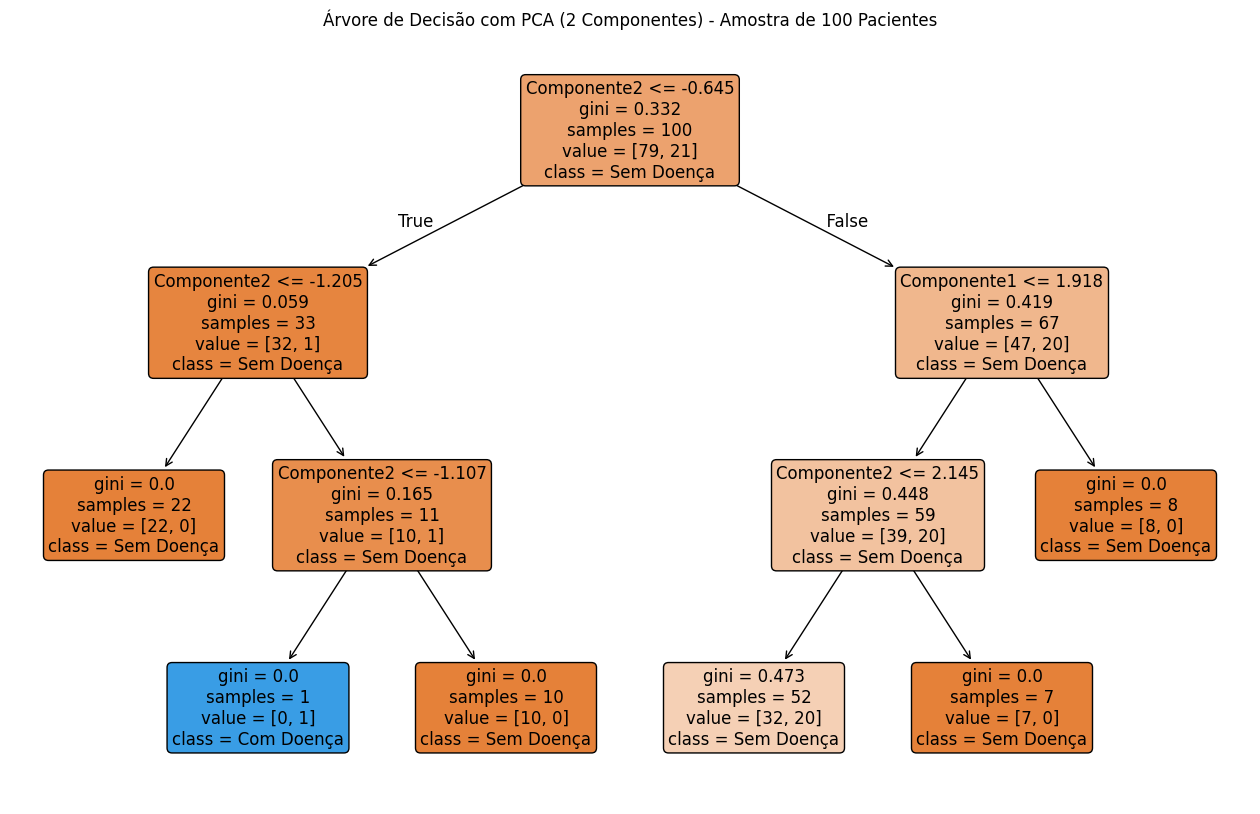

In [16]:
# Treinar uma árvore rasa para facilitar a visualização
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_pca, y_sample)

# Plotar a árvore
plt.figure(figsize=(16, 10))
plot_tree(
    clf,
    feature_names=["Componente1", "Componente2"],
    class_names=["Sem Doença", "Com Doença"], # ajuste
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title("Árvore de Decisão com PCA (2 Componentes) - Amostra de 100 Pacientes")
plt.show()


In [17]:
print(f"Número de componentes selecionados: {pca.n_components_}")

Número de componentes selecionados: 2


In [18]:
# Cria um DataFrame com os pesos de cada atributo em cada componente
componentes = pd.DataFrame(
    pca.components_,
    columns=X_sample.columns,
    index=["PC1", "PC2"]
)

# Mostra os atributos que mais influenciaram o PC1
print("Atributos mais relevantes no PC1:")
print(componentes.loc["PC1"].abs().sort_values(ascending=False).head(10))

# E no PC2
print("\nAtributos mais relevantes no PC2:")
print(componentes.loc["PC2"].abs().sort_values(ascending=False).head(10))

Atributos mais relevantes no PC1:
Sugar Consumption_Medium    0.425406
High LDL Cholesterol        0.419188
Exercise Habits_Medium      0.350383
Sugar Consumption_Low       0.347273
Exercise Habits_Low         0.330920
Fasting Blood Sugar         0.258905
BMI                         0.214015
Stress Level_Low            0.180014
Low HDL Cholesterol         0.170575
Age                         0.142163
Name: PC1, dtype: float64

Atributos mais relevantes no PC2:
Stress Level_Medium         0.452871
Stress Level_Low            0.437657
Sleep Hours                 0.390389
High Blood Pressure         0.354335
Triglyceride Level          0.252498
Diabetes                    0.242270
Low HDL Cholesterol         0.241515
Exercise Habits_Low         0.189902
Sugar Consumption_Medium    0.132295
Blood Pressure              0.126254
Name: PC2, dtype: float64



O PC1 parece estar capturando um componente metabólico e de estilo de vida, fortemente influenciado por hábitos de consumo de açúcar, nível de colesterol LDL e nível de atividade física.

O PC2 parece capturar uma dimensão psicológica e cardiovascular, com forte influência de nível de estresse, qualidade do sono e pressão arterial.



In [ ]:
## Para o treinamento, fazer o PCA com 0.95% de componentes, para não prejudicar o treinamento. 

# n_components=0.95 → o PCA seleciona quantos componentes forem necessários para manter 95% da variância dos dados originais;

In [50]:
## Verificando a distribuição dos dados

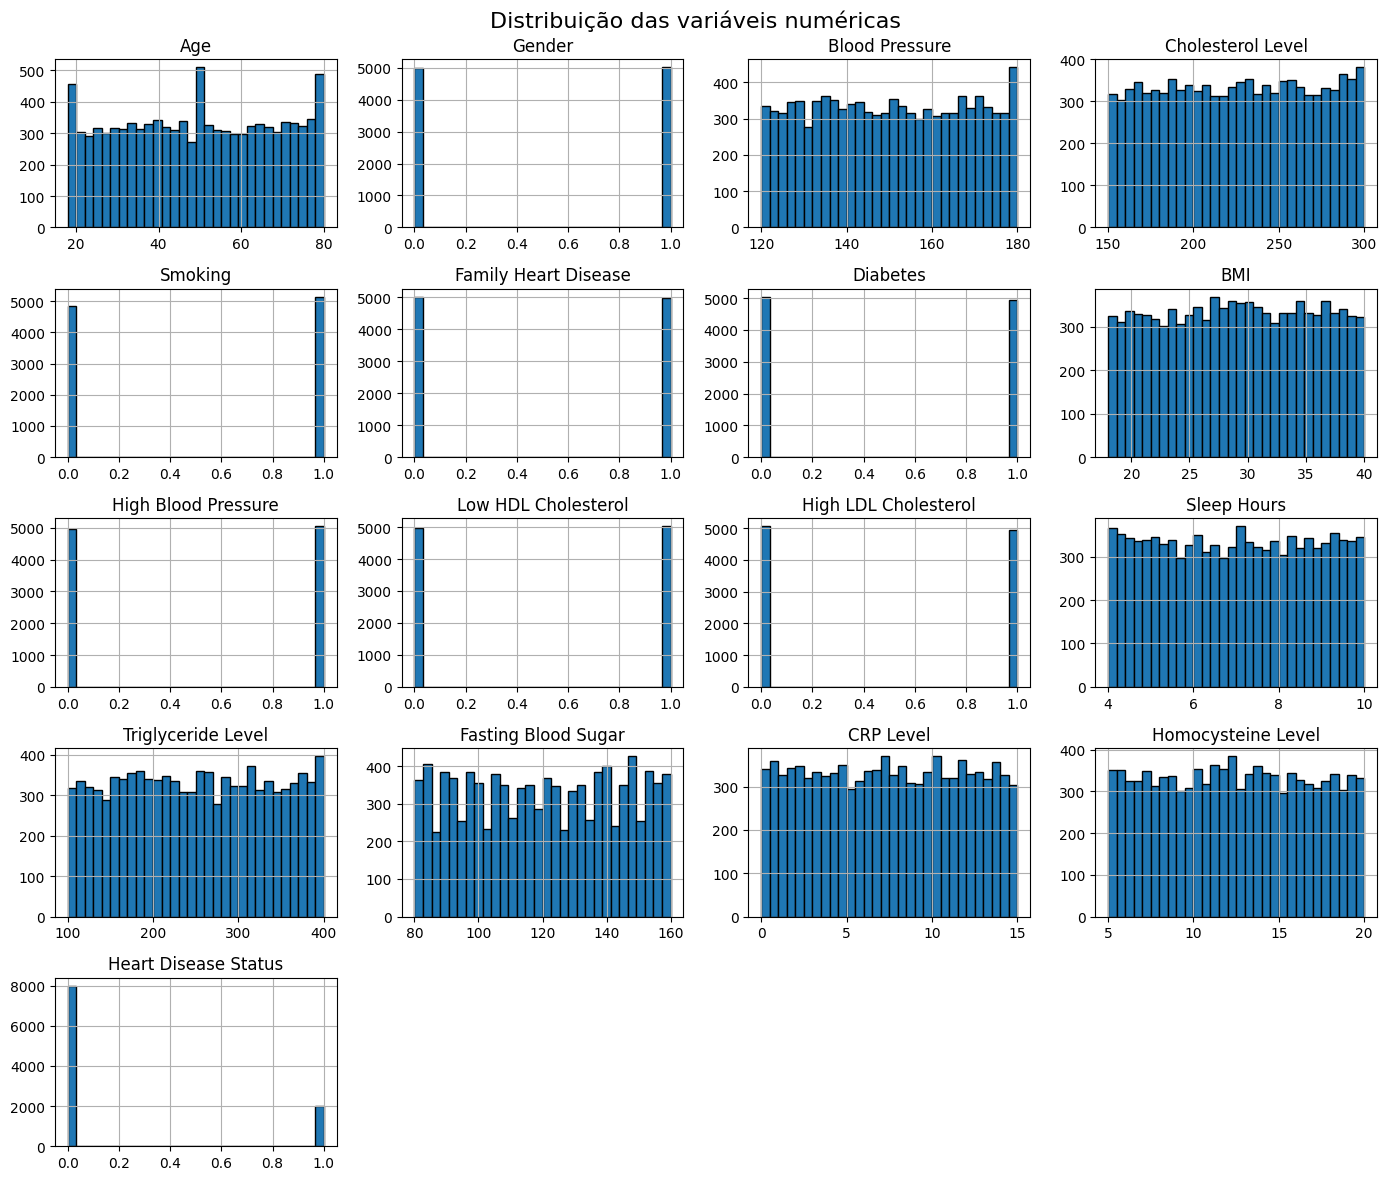

In [30]:
# Histogramas para todas as variáveis numéricas
data_encoded.select_dtypes(include=['int64', 'float64']).hist(
    figsize=(14, 12), bins=30, edgecolor='black')
plt.suptitle("Distribuição das variáveis numéricas", fontsize=16)
plt.tight_layout()
plt.show()

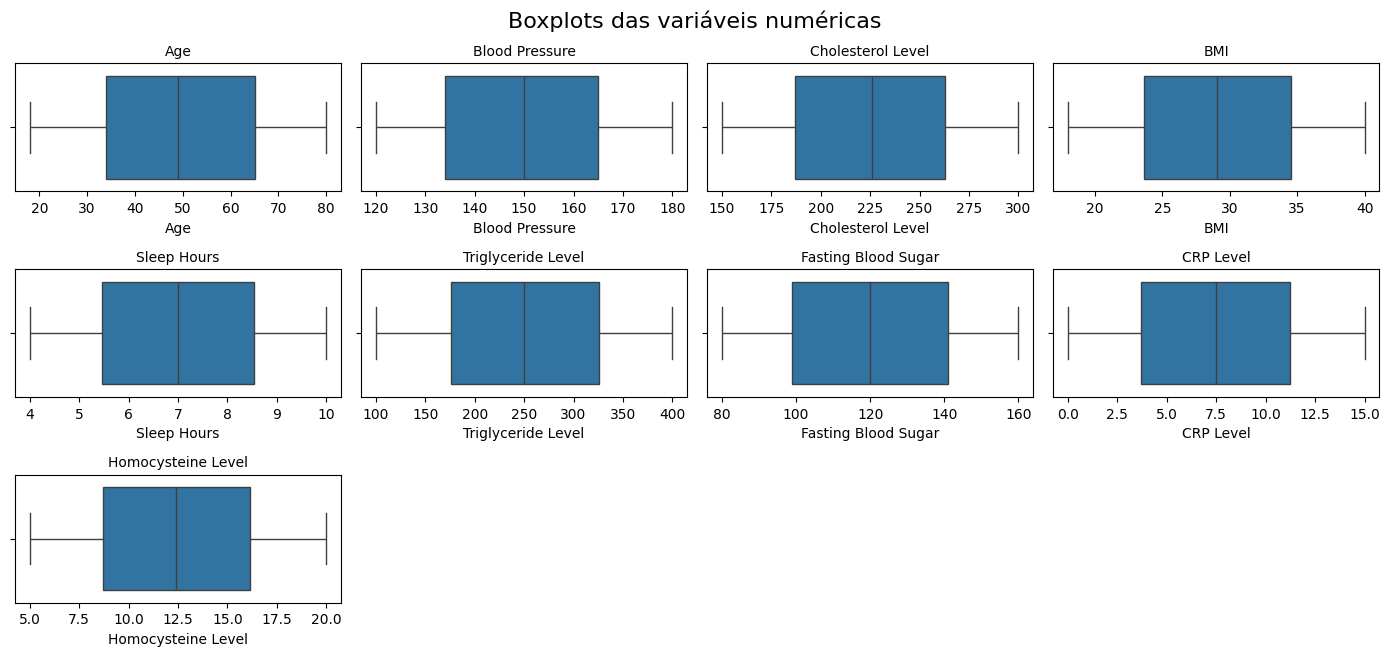

In [31]:
# Criar boxplots para cada variável numérica
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(14, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(5, 4, i)
    sns.boxplot(x=data[col])
    plt.title(col, fontsize=10)
    plt.tight_layout()

plt.suptitle("Boxplots das variáveis numéricas", y=1.02, fontsize=16)
plt.show()

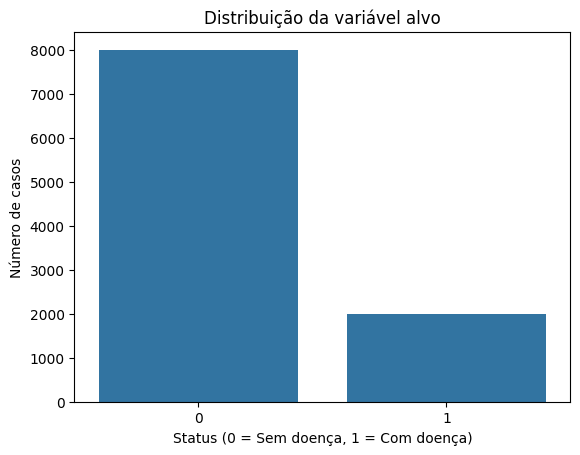

In [19]:
sns.countplot(x='Heart Disease Status', data=data_encoded)
plt.title('Distribuição da variável alvo')
plt.xlabel('Status (0 = Sem doença, 1 = Com doença)')
plt.ylabel('Número de casos')
plt.show()

In [19]:
# Verifica a contagem das classes (0 e 1)
print(data_encoded['Heart Disease Status'].value_counts())

Heart Disease Status
0    8000
1    2000
Name: count, dtype: int64


In [20]:
# Definir o X e y
X = data_encoded.drop('Heart Disease Status', axis=1)
y = data_encoded['Heart Disease Status']

In [21]:
# Aplicar SMOTE para gerar 300 amostras por classe
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy={0: 8000, 1: 6000}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [22]:
# Criar novo DataFrame com os dados aumentados
data_resampled = pd.DataFrame(X_resampled, columns=X.columns)
data_resampled['Heart Disease Status'] = y_resampled

# Verificar a nova distribuição
print(data_resampled['Heart Disease Status'].value_counts())

Heart Disease Status
0    8000
1    6000
Name: count, dtype: int64


In [23]:
# Aplicando o PCA para o treinamento. 
# PCA com 0.95% de componentes, para não prejudicar o treinamento. 
# n_components=0.95 → o PCA seleciona quantos componentes forem necessários para manter 95% da variância dos dados originais;

# Separar X e y com base na coluna alvo
X = data_resampled.drop(columns=["Heart Disease Status"])
y = data_resampled["Heart Disease Status"]

# Normalizar os dados (PCA exige normalização)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA para reduzir para 2 componentes principais
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)


In [24]:
# Verificar quantos componentes foram selecionados
print(f"Número de componentes selecionados: {pca.n_components_}")

Número de componentes selecionados: 20


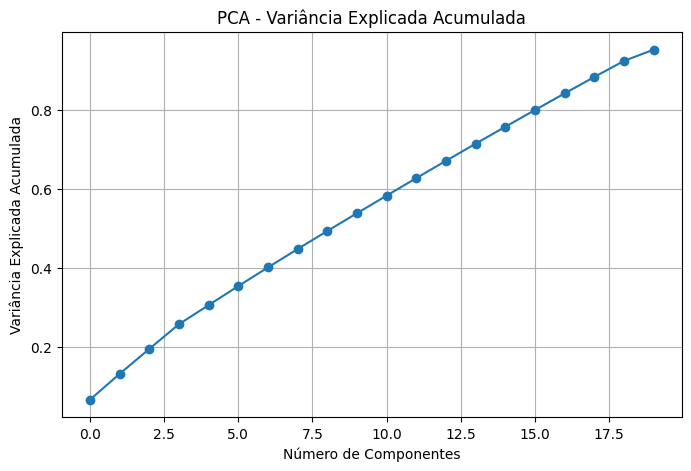

In [25]:
# Proporção de variância explicada acumulada
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Explicada Acumulada")
plt.title("PCA - Variância Explicada Acumulada")
plt.grid(True)
plt.show()


In [25]:
## Os dados estão desbalanceados. Utilizar a técnica SMOTE(Synthetic Minority Over-sampling Technique) para criar dados sintéticos.

# 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y_resampled, random_state=42)


# Normalizando os dados(Deixar tudo na mesma escala)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## SMOTE  (já foi feito)
#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Verificar o novo balanceamento
#print(pd.Series(y_train_resampled).value_counts())



In [59]:
# Agora está balanceado e normalizado.

Treinamento do modelo Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [27]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [28]:
## Avaliar a acuracia nos dados de treino 

y_pred_treino = rf.predict(X_train_scaled)

print(f'Acurácia de treino: {accuracy_score(y_train, y_pred_treino)}')



Acurácia de treino: 1.0


In [29]:
## Avaliar a acuracia nos dados de teste

y_pred_teste = rf.predict(X_test_scaled)

print(f'Acurácia de teste: {accuracy_score(y_test, y_pred_teste)}')

Acurácia de teste: 0.8114285714285714


In [64]:
"""
    A acurácia de treino está dando 1.0, ou seja o modelo aprendeu demais os dados
    de treino. Ocorreu overfitting. 

    Com o max_depth=15, ele reduz a acurácia de treino, isso melhora na questão do overfitting. 
    Ou seja, com árvores menos profundas, reduz a chance de overfitting.

    Um f1-score bom não significa que não houve overfitting.

    Como ajustar isso então na função fitness no GA?

    Sugestão: Penalizar árvores mais profundas e variações(desvio padrão):

        # Penaliza variações e profundidade
        penalty = (scores.std() * 0.5) + (int(max_depth) * 0.001)




"""

'\n    A acurácia de treino está dando 1.0, ou seja o modelo aprendeu demais os dados\n    de treino. Ocorreu overfitting. \n\n    Com o max_depth=15, ele reduz a acurácia de treino, isso melhora na questão do overfitting. \n    Ou seja, com árvores menos profundas, reduz a chance de overfitting.\n\n    Um f1-score bom não significa que não houve overfitting.\n\n    Como ajustar isso então na função fitness no GA?\n\n    Sugestão: Penalizar árvores mais profundas e variações(desvio padrão):\n\n        # Penaliza variações e profundidade\n        penalty = (scores.std() * 0.5) + (int(max_depth) * 0.001)\n\n\n\n\n'

In [30]:
# Relatório de desempenho
print(classification_report(y_test, y_pred_teste))
print("ROC AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:,1]))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      2400
           1       0.88      0.65      0.75      1800

    accuracy                           0.81      4200
   macro avg       0.83      0.79      0.80      4200
weighted avg       0.82      0.81      0.81      4200

ROC AUC Score: 0.8607269675925926


In [31]:
## Otimização com o algoritmo genético

## Função de avaliação (um conjunto de hiperparâmetros)

def evaluate(individual): 

    # Extraíndo os valores dos genes
    n_estimators = int(individual[0])
    max_depth = int(individual[1])
    min_sample_split = int(individual[2])


    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_sample_split,
        class_weight='balanced',
        random_state=42
    )

    # Avaliar com validação cruzada com F1-score (3 folds)
    scores = cross_val_score(
        model, X_train_scaled, y_train, 
        cv=3, scoring='f1'
    )

    # Retornando a média do F1 - penalty, como tupla (DEAP exige tupla)

    # Penaliza variações e profundidade
    # penalização por instabilidade entre folds  # penalização leve por profundidade
    penalty = (scores.std() * 0.5) + (int(max_depth) * 0.001)
    return (scores.mean() - penalty,)

# Espaço de busca
BOUNDS = {
    "n_estimators": (50, 70),
    "max_depth": (2, 15),
    "min_samples_split": (2, 10),
}


# Criando o tipo "fitness" que será MAXIMIZADO
# weights=(1.0,): queremos maximizar o F1-score
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# Criando o tipo "individual" — ou seja, uma lista com o nosso conjunto de genes
creator.create("Individual", list, fitness=creator.FitnessMax)

# Um indivíduo é um vetor [n_estimators, max_depth, min_samples_split]

## Toolbox: define como os indivíduos são criados e manipulados

toolbox = base.Toolbox()

# Define o espaço de busca de cada gene
toolbox.register("attr_n_estimators", random.randint, 50, 70)
toolbox.register("attr_max_depth", random.randint, 2, 15)
toolbox.register("attr_min_samples_split", random.randint, 2, 10)

# Cria um indivíduo com esses três atributos
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_n_estimators, toolbox.attr_max_depth, toolbox.attr_min_samples_split), n=1)

# População: uma lista de indivíduos
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


####  Operadores genéticos

# Função de avaliação
toolbox.register("evaluate", evaluate)

# Cruzamento entre indivíduos (uniforme = mistura gene a gene)
toolbox.register("mate", tools.cxUniform, indpb=0.5)

# Mutação: altera genes aleatoriamente dentro dos limites
toolbox.register("mutate", tools.mutUniformInt, low=[50, 2, 2], up=[70, 15, 10], indpb=0.3)

# Seleção: seleciona os melhores por torneio
toolbox.register("select", tools.selTournament, tournsize=3)


# indpb=0.2: cada gene tem 20% de chance de sofrer mutação
# tournsize=3: escolhe o melhor entre 3 indivíduos aleatórios


# Função principal que roda o algoritmo genético

def run_ga():
    start_time = time.time()  # início do tempo de execução

    process = psutil.Process()
    mem_before = process.memory_info().rss / 1024**2  # memória em MB antes

    # Cria a população inicial com 10 indivíduos
    pop = toolbox.population(n=10)

    # Hall of Fame: armazena o melhor indivíduo encontrado
    hof = tools.HallOfFame(1)

    # Estatísticas para acompanhar a evolução
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)


    # Executa o algoritmo genético por 8 gerações
    pop, log = algorithms.eaSimple(
        pop, toolbox,
        cxpb=0.5,          # probabilidade de cruzamento
        mutpb=0.3,         # probabilidade de mutação
        ngen=8,           # número de gerações
        stats=stats,      # Coleta estatísticas de desempenho da população. Ativado
        halloffame=hof,   # Armazena o melhor indivíduo encontrado. Ativado
        verbose=True      # Exibe os logs durante a execução. True
    )

    mem_after = process.memory_info().rss / 1024**2  # memória em MB depois
    end_time = time.time()  ## tempo final

    exec_time = end_time - start_time   ## tempo total da execução.
    mem_used = mem_after - mem_before  ## Total de memória usada. 


    # Extrair os melhores hiperparâmetros encontrados
    best_n, best_depth, best_split = map(int, hof[0])

     # Treinar o modelo com os dados de treino balanceado
    best_model = RandomForestClassifier(
        n_estimators=best_n,
        max_depth=best_depth,
        min_samples_split=best_split,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    best_model.fit(X_train_scaled, y_train)

    # Avaliação no treino
    y_pred_train = best_model.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Avaliação no teste
    y_pred_test = best_model.predict(X_test_scaled)
    y_proba_test = best_model.predict_proba(X_test_scaled)[:, 1]

    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_proba_test)

    # Salvando o espaço de busca.
    search_space_str = ", ".join([f"{param}: {bounds}" for param, bounds in BOUNDS.items()])

    # Tabela com resultados
    results_table = pd.DataFrame([{
        "Tempo de Execução (s)": round(exec_time, 2),
        "Memória Usada (MB)": round(mem_used, 2),
        "Melhor Solução": hof[0],
        "Fitness da Solução": round(hof[0].fitness.values[0], 4),
        "Acurácia (treino)": round(train_accuracy, 4),
        "Acurácia (teste)": round(test_accuracy, 4),
        "F1-score (teste)": round(test_f1, 4),
        "ROC AUC (teste)": round(test_auc, 4),
        "Espaço de Busca": search_space_str
    }])

    print("\n Tabela de desempenho do algoritmo genético:")
    print(results_table.to_string(index=False))

    # Salvar em arquivo .txt
    with open("resultado_ga_4.txt", "w", encoding="utf-8") as f:
        f.write("Tabela de desempenho do algoritmo genético:\n")
        f.write(results_table.to_string(index=False))
        f.write("\n")


    return hof[0], log, results_table # Retorna o melhor indivíduo e o histórico da evolução



gen	nevals	avg     	max     
0  	10    	0.678803	0.694515
1  	7     	0.68622 	0.694515
2  	6     	0.692935	0.694515
3  	8     	0.693844	0.694701
4  	7     	0.692558	0.697668
5  	9     	0.69444 	0.697668
6  	10    	0.695603	0.70153 
7  	6     	0.698219	0.70153 
8  	7     	0.70051 	0.705868

 Tabela de desempenho do algoritmo genético:
 Tempo de Execução (s)  Memória Usada (MB) Melhor Solução  Fitness da Solução  Acurácia (treino)  Acurácia (teste)  F1-score (teste)  ROC AUC (teste)                                                        Espaço de Busca
                241.29                7.84    [62, 12, 5]              0.7059             0.9573            0.7933            0.7336           0.8456 n_estimators: (50, 70), max_depth: (2, 15), min_samples_split: (2, 10)
 
 

🏆 Melhor indivíduo (hiperparâmetros otimizados): [62, 12, 5]
F1-score médio na validação cruzada: 0.7059


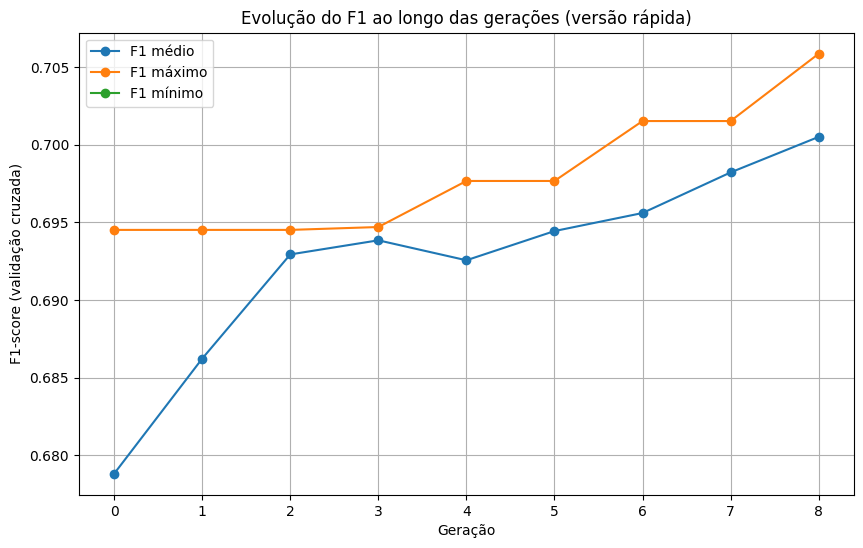

In [44]:
# Roda o algoritmo genético
best_individual, logbook, results_df = run_ga()

# Mostra os melhores hiperparâmetros encontrados
print(" ")
print(" ")
print(f"\n🏆 Melhor indivíduo (hiperparâmetros otimizados): {best_individual}")
print(f"F1-score médio na validação cruzada: {best_individual.fitness.values[0]:.4f}")

# Gráfico de evolução
gen = logbook.select("gen")
avg = logbook.select("avg")
max_ = logbook.select("max")
min_ = logbook.select("min")

plt.figure(figsize=(10, 6))
plt.plot(gen, avg, label="F1 médio", marker='o')
plt.plot(gen, max_, label="F1 máximo", marker='o')
plt.plot(gen, min_, label="F1 mínimo", marker='o')
plt.xlabel("Geração")
plt.ylabel("F1-score (validação cruzada)")
plt.title("Evolução do F1 ao longo das gerações (versão rápida)")
plt.grid(True)
plt.legend()
plt.show()

In [39]:
"""
Significado do que está sendo retornado:

gen ->	Número da geração
nevals ->	Quantos indivíduos foram avaliados nessa geração
avg ->	Média dos F1-scores da população
max	-> Melhor F1-score da geração



"""

'\nSignificado do que está sendo retornado:\n\ngen ->\tNúmero da geração\nnevals ->\tQuantos indivíduos foram avaliados nessa geração\navg ->\tMédia dos F1-scores da população\nmax\t-> Melhor F1-score da geração\n\n\n\n'

In [ ]:
## Depois, fazer testes com uma profundidade de árvore menor e mais gerações.
## Objetivo: Tentar melhorar o tempo de execução e melhorar as métricas de avaliação. 
## E registrar essa mudança. Mostrar que a profundidade da árvore reduzida pode aumentar a acurácia e melhorar o tempo de execução.


In [ ]:
# Relatório de classificação feito com o 1º Experimento com GA

## Construindo o melhor modelo com os parâmetros ótimos
# Constrói o melhor modelo com os parâmetros ótimos
best_model = RandomForestClassifier(
    n_estimators=int(best_individual[0]),
    max_depth=int(best_individual[1]),
    min_samples_split=int(best_individual[2]),
    class_weight='balanced',
    random_state=42
)

# Treina com o conjunto balanceado
best_model.fit(X_train_scaled, y_train)


# Avalia no conjunto de teste (desbalanceado)
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]


print("\n📊 Avaliação final no conjunto de teste:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")



📊 Avaliação final no conjunto de teste:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      2400
           1       0.83      0.66      0.74      1800

    accuracy                           0.80      4200
   macro avg       0.81      0.78      0.79      4200
weighted avg       0.80      0.80      0.79      4200

ROC AUC Score: 0.8472


In [51]:
# Relatório de classificação feito com o 2º Experimento com GA

## Construindo o melhor modelo com os parâmetros ótimos
# Constrói o melhor modelo com os parâmetros ótimos
best_model = RandomForestClassifier(
    n_estimators=int(best_individual[0]),
    max_depth=int(best_individual[1]),
    min_samples_split=int(best_individual[2]),
    class_weight='balanced',
    random_state=42
)

# Treina com o conjunto balanceado
best_model.fit(X_train_scaled, y_train)


# Avalia no conjunto de teste (desbalanceado)
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]


print("\n📊 Avaliação final no conjunto de teste:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")



📊 Avaliação final no conjunto de teste:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85      2400
           1       0.88      0.66      0.75      1800

    accuracy                           0.82      4200
   macro avg       0.83      0.80      0.80      4200
weighted avg       0.83      0.82      0.81      4200

ROC AUC Score: 0.8574


In [58]:
# Relatório de classificação feito com o 3º Experimento com GA

## Construindo o melhor modelo com os parâmetros ótimos
# Constrói o melhor modelo com os parâmetros ótimos
best_model = RandomForestClassifier(
    n_estimators=int(best_individual[0]),
    max_depth=int(best_individual[1]),
    min_samples_split=int(best_individual[2]),
    class_weight='balanced',
    random_state=42
)

# Treina com o conjunto balanceado
best_model.fit(X_train_scaled, y_train)


# Avalia no conjunto de teste (desbalanceado)
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]


print("\n📊 Avaliação final no conjunto de teste:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


📊 Avaliação final no conjunto de teste:
              precision    recall  f1-score   support

           0       0.78      0.92      0.84      2400
           1       0.86      0.66      0.74      1800

    accuracy                           0.81      4200
   macro avg       0.82      0.79      0.79      4200
weighted avg       0.81      0.81      0.80      4200

ROC AUC Score: 0.8526


In [ ]:
## Relatório de classificação do 1º experimento com GA:

def gerar_relatorio_classificacao_txt():
    relatorio = """\
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      2400
           1       0.83      0.66      0.74      1800

    accuracy                           0.80      4200
   macro avg       0.81      0.78      0.79      4200
weighted avg       0.80      0.80      0.79      4200
"""
    with open("relatorio_classificacao_GA_1.txt", "w", encoding="utf-8") as f:
        f.write(relatorio)

if __name__ == "__main__":
    gerar_relatorio_classificacao_txt()
    print("Arquivo 'relatorio_classificacao_GA_1.txt' criado com sucesso!")

Arquivo 'relatorio_classificacao_GA_1.txt' criado com sucesso!


In [ ]:
## Relatório de classificação do 2º experimento com GA:

def gerar_relatorio_classificacao_txt():
    relatorio = """\
              precision    recall  f1-score   support

           0       0.78      0.93      0.85      2400
           1       0.88      0.66      0.75      1800

    accuracy                           0.82      4200
   macro avg       0.83      0.80      0.80      4200
weighted avg       0.83      0.82      0.81      4200
"""
    with open("relatorio_classificacao_GA_2.txt", "w", encoding="utf-8") as f:
        f.write(relatorio)

if __name__ == "__main__":
    gerar_relatorio_classificacao_txt()
    print("Arquivo 'relatorio_classificacao_GA_2.txt' criado com sucesso!")

Arquivo 'relatorio_classificacao_GA_2.txt' criado com sucesso!


In [59]:
## Relatório de classificação do 3º experimento com GA:

def gerar_relatorio_classificacao_txt():
    relatorio = """\
              precision    recall  f1-score   support

           0       0.78      0.92      0.84      2400
           1       0.86      0.66      0.74      1800

    accuracy                           0.81      4200
   macro avg       0.82      0.79      0.79      4200
weighted avg       0.81      0.81      0.80      4200
"""
    with open("relatorio_classificacao_GA_3.txt", "w", encoding="utf-8") as f:
        f.write(relatorio)

if __name__ == "__main__":
    gerar_relatorio_classificacao_txt()
    print("Arquivo 'relatorio_classificacao_GA_3.txt' criado com sucesso!")

Arquivo 'relatorio_classificacao_GA_3.txt' criado com sucesso!


In [ ]:
###################          ########################          #####################         #############################

In [70]:
""" Evolução diferencial """

' Evolução diferencial '

In [44]:
# Função de avaliação para DE
def evaluate_de(params):
    n_estimators = int(params[0])
    max_depth = int(params[1])
    min_samples_split = int(params[2])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    scores = cross_val_score(model, X_train_scaled, y_train,
                             cv=3, scoring='f1')


    penalty = (scores.std() * 0.5) + (max_depth * 0.001)
    fitness = scores.mean() - penalty

    # Log para acompanhamento
    print(f"[INFO] F1 médio: {scores.mean():.4f} | Penalidade: {penalty:.4f} | Fitness real: {fitness:.4f}")

    return -fitness # DE minimiza

# Definição dos limites de busca
bounds = [(170, 190), (10, 15), (2, 20)]

# Execução do DE
start_time = time.time()
process = psutil.Process()
mem_before = process.memory_info().rss / 1024**2

result = differential_evolution(
    evaluate_de,
    bounds,
    strategy='best1bin',  ## Estratégia padrão. Significa: o melhor vetor da população atual é usado como base (a), para construir o mutante. "bin" indica que o cruzamento (recombinação) é feito de forma binária, gene a gene, usando probabilidade.
    mutation=(0.5, 1), # Parâmetro F (fator de escala da diferença vetorial). Está sendo sorteado aleatoriamente entre 0.5 e 1.0 a cada geração. Esse valor controla o quanto a diferença (b - c) impacta na nova solução.
    recombination=0.7, 
    seed=42,
    tol=0.01,  # Critério de tolerância para parada antecipada: Se a mudança no melhor valor da função objetivo entre gerações for menor que 0.01, o algoritmo pode parar antes do maxiter
    maxiter=20,  # Número máximo de gerações (iterações). Ou seja, o algoritmo rodará no máximo 20 vezes, a não ser que a tolerância seja atingida antes.
    popsize=10,  # Tamanho da população, ou seja, quantas soluções candidatas existem por geração. 10 x len(bound), ou seja 30 indivíduos. 
    disp=True    # Mostra o desempenho durante a execução.
)

mem_after = process.memory_info().rss / 1024**2
end_time = time.time()

exec_time = end_time - start_time   ## tempo total da execução.
mem_used = mem_after - mem_before  ## Total de memória usada. 

# Resultados
best_n, best_depth, best_split = map(int, result.x)
best_model = RandomForestClassifier(
    n_estimators=best_n,
    max_depth=best_depth,
    min_samples_split=best_split,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
best_model.fit(X_train_scaled, y_train)

y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)
y_proba_test = best_model.predict_proba(X_test_scaled)[:, 1]

# Métricas
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, y_proba_test)


# Nomes dos parâmetros (na mesma ordem da lista 'bounds')
param_names = ["n_estimators", "max_depth", "min_samples_split"]

# Geração da string do espaço de busca
search_space_str = ", ".join([
    f"{name}: {b}" for name, b in zip(param_names, bounds)
])

# Tabela de resultados
results_table = pd.DataFrame([{
    "Tempo de Execução (s)": round(exec_time, 2),
    "Memória Usada (MB)": round(mem_used, 2),
    "Melhor Solução": [best_n, best_depth, best_split],
    "Fitness da Solução": -round(result.fun, 4),
    "Acurácia (treino)": round(train_accuracy, 4),
    "Acurácia (teste)": round(test_accuracy, 4),
    "F1-score (teste)": round(test_f1, 4),
    "ROC AUC (teste)": round(test_auc, 4),
    "Espaço de Busca": search_space_str
}])


print("\n📊 Tabela de desempenho da Evolução Diferencial:")
print(results_table.to_string(index=False))


# Salvar em arquivo .txt
with open("resultado_evoDif_6.txt", "w", encoding="utf-8") as f:
    f.write("Tabela de desempenho do algoritmo de Evolução Diferencial:\n")
    f.write(results_table.to_string(index=False))
    f.write("\n")




[INFO] F1 médio: 0.7215 | Penalidade: 0.0190 | Fitness real: 0.7025
[INFO] F1 médio: 0.7207 | Penalidade: 0.0188 | Fitness real: 0.7019
[INFO] F1 médio: 0.7231 | Penalidade: 0.0145 | Fitness real: 0.7086
[INFO] F1 médio: 0.7190 | Penalidade: 0.0163 | Fitness real: 0.7027
[INFO] F1 médio: 0.7154 | Penalidade: 0.0153 | Fitness real: 0.7001
[INFO] F1 médio: 0.7267 | Penalidade: 0.0169 | Fitness real: 0.7098
[INFO] F1 médio: 0.7247 | Penalidade: 0.0165 | Fitness real: 0.7082
[INFO] F1 médio: 0.7219 | Penalidade: 0.0173 | Fitness real: 0.7047
[INFO] F1 médio: 0.7174 | Penalidade: 0.0160 | Fitness real: 0.7013
[INFO] F1 médio: 0.7143 | Penalidade: 0.0155 | Fitness real: 0.6989
[INFO] F1 médio: 0.7205 | Penalidade: 0.0174 | Fitness real: 0.7031
[INFO] F1 médio: 0.7158 | Penalidade: 0.0153 | Fitness real: 0.7005
[INFO] F1 médio: 0.7192 | Penalidade: 0.0173 | Fitness real: 0.7019
[INFO] F1 médio: 0.7239 | Penalidade: 0.0170 | Fitness real: 0.7069
[INFO] F1 médio: 0.7233 | Penalidade: 0.0149 | F

In [49]:
# Nomes dos parâmetros (na mesma ordem da lista 'bounds')
param_names = ["n_estimators", "max_depth", "min_samples_split"]

# Geração da string do espaço de busca
search_space_str = ", ".join([
    f"{name}: {b}" for name, b in zip(param_names, bounds)
])

In [50]:
search_space_str


'n_estimators: (50, 150), max_depth: (5, 40), min_samples_split: (2, 20)'

In [51]:

best_params = [int(x) for x in result.x]

In [35]:
# Relatório de classificação feito com o 1º Experimento com ED

## Construindo o melhor modelo com os parâmetros ótimos
# Constrói o melhor modelo com os parâmetros ótimos
# Extrair os melhores hiperparâmetros encontrados pela ED
best_params = [int(x) for x in result.x]
n_estimators, max_depth, min_samples_split = best_params

# Treinar o modelo com os melhores hiperparâmetros
model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Fazer previsões
y_pred = model.predict(X_test_scaled)

# Gerar o relatório de classificação
report = classification_report(y_test, y_pred, digits=4)

# Exibir no console
print("\nRelatório de Classificação (teste):")
print(report)

# Salvar em arquivo
with open("relatorio_classificacao_ED_1.txt", "w", encoding="utf-8") as f:
    f.write("Relatório de Classificação - Evolução Diferencial:\n")
    f.write(report)


Relatório de Classificação (teste):
              precision    recall  f1-score   support

           0     0.7736    0.9267    0.8432      2400
           1     0.8672    0.6383    0.7354      1800

    accuracy                         0.8031      4200
   macro avg     0.8204    0.7825    0.7893      4200
weighted avg     0.8137    0.8031    0.7970      4200



In [ ]:
# Relatório de classificação feito com o 2º Experimento com ED

## Construindo o melhor modelo com os parâmetros ótimos
# Constrói o melhor modelo com os parâmetros ótimos
# Extrair os melhores hiperparâmetros encontrados pela ED
best_params = [int(x) for x in result.x]
n_estimators, max_depth, min_samples_split = best_params

# Treinar o modelo com os melhores hiperparâmetros
model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Fazer previsões
y_pred = model.predict(X_test_scaled)

# Gerar o relatório de classificação
report = classification_report(y_test, y_pred, digits=4)

# Exibir no console
print("\nRelatório de Classificação (teste):")
print(report)

# Salvar em arquivo
with open("relatorio_classificacao_ED_2.txt", "w", encoding="utf-8") as f:
    f.write("Relatório de Classificação - Evolução Diferencial:\n")
    f.write(report)


Relatório de Classificação (teste):
              precision    recall  f1-score   support

           0     0.7678    0.9329    0.8424      2400
           1     0.8746    0.6239    0.7283      1800

    accuracy                         0.8005      4200
   macro avg     0.8212    0.7784    0.7853      4200
weighted avg     0.8136    0.8005    0.7935      4200



In [35]:
# Relatório de classificação feito com o 3º Experimento com ED

## Construindo o melhor modelo com os parâmetros ótimos
# Constrói o melhor modelo com os parâmetros ótimos
# Extrair os melhores hiperparâmetros encontrados pela ED
best_params = [int(x) for x in result.x]
n_estimators, max_depth, min_samples_split = best_params

# Treinar o modelo com os melhores hiperparâmetros
model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Fazer previsões
y_pred = model.predict(X_test_scaled)

# Gerar o relatório de classificação
report = classification_report(y_test, y_pred, digits=4)

# Exibir no console
print("\nRelatório de Classificação (teste):")
print(report)

# Salvar em arquivo
with open("relatorio_classificacao_ED_3.txt", "w", encoding="utf-8") as f:
    f.write("Relatório de Classificação - Evolução Diferencial:\n")
    f.write(report)


Relatório de Classificação (teste):
              precision    recall  f1-score   support

           0     0.7746    0.9267    0.8439      2400
           1     0.8676    0.6406    0.7370      1800

    accuracy                         0.8040      4200
   macro avg     0.8211    0.7836    0.7904      4200
weighted avg     0.8145    0.8040    0.7981      4200



In [37]:
# Relatório de classificação feito com o 4º Experimento com ED

## Construindo o melhor modelo com os parâmetros ótimos
# Constrói o melhor modelo com os parâmetros ótimos
# Extrair os melhores hiperparâmetros encontrados pela ED
best_params = [int(x) for x in result.x]
n_estimators, max_depth, min_samples_split = best_params

# Treinar o modelo com os melhores hiperparâmetros
model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Fazer previsões
y_pred = model.predict(X_test_scaled)

# Gerar o relatório de classificação
report = classification_report(y_test, y_pred, digits=4)

# Exibir no console
print("\nRelatório de Classificação (teste):")
print(report)

# Salvar em arquivo
with open("relatorio_classificacao_ED_4.txt", "w", encoding="utf-8") as f:
    f.write("Relatório de Classificação - Evolução Diferencial:\n")
    f.write(report)


Relatório de Classificação (teste):
              precision    recall  f1-score   support

           0     0.7767    0.9350    0.8486      2400
           1     0.8810    0.6417    0.7425      1800

    accuracy                         0.8093      4200
   macro avg     0.8289    0.7883    0.7955      4200
weighted avg     0.8214    0.8093    0.8031      4200



In [39]:
# Relatório de classificação feito com o 5º Experimento com ED

## Construindo o melhor modelo com os parâmetros ótimos
# Constrói o melhor modelo com os parâmetros ótimos
# Extrair os melhores hiperparâmetros encontrados pela ED
best_params = [int(x) for x in result.x]
n_estimators, max_depth, min_samples_split = best_params

# Treinar o modelo com os melhores hiperparâmetros
model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Fazer previsões
y_pred = model.predict(X_test_scaled)

# Gerar o relatório de classificação
report = classification_report(y_test, y_pred, digits=4)

# Exibir no console
print("\nRelatório de Classificação (teste):")
print(report)

# Salvar em arquivo
with open("relatorio_classificacao_ED_5.txt", "w", encoding="utf-8") as f:
    f.write("Relatório de Classificação - Evolução Diferencial:\n")
    f.write(report)


Relatório de Classificação (teste):
              precision    recall  f1-score   support

           0     0.7752    0.9337    0.8471      2400
           1     0.8785    0.6389    0.7398      1800

    accuracy                         0.8074      4200
   macro avg     0.8268    0.7863    0.7934      4200
weighted avg     0.8195    0.8074    0.8011      4200



In [45]:
# Relatório de classificação feito com o 6º Experimento com ED

## Construindo o melhor modelo com os parâmetros ótimos
# Constrói o melhor modelo com os parâmetros ótimos
# Extrair os melhores hiperparâmetros encontrados pela ED
best_params = [int(x) for x in result.x]
n_estimators, max_depth, min_samples_split = best_params

# Treinar o modelo com os melhores hiperparâmetros
model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Fazer previsões
y_pred = model.predict(X_test_scaled)

# Gerar o relatório de classificação
report = classification_report(y_test, y_pred, digits=4)

# Exibir no console
print("\nRelatório de Classificação (teste):")
print(report)

# Salvar em arquivo
with open("relatorio_classificacao_ED_6.txt", "w", encoding="utf-8") as f:
    f.write("Relatório de Classificação - Evolução Diferencial:\n")
    f.write(report)



Relatório de Classificação (teste):
              precision    recall  f1-score   support

           0     0.7756    0.9358    0.8482      2400
           1     0.8819    0.6389    0.7410      1800

    accuracy                         0.8086      4200
   macro avg     0.8287    0.7874    0.7946      4200
weighted avg     0.8211    0.8086    0.8022      4200

